# Downloading the ZIP File and Extracting it. 

In [7]:
!wget https://www.dropbox.com/s/1ewy9gw42sty8pt/cxr_plaksha_assignment_qure.zip?dl=0

--2022-02-16 16:37:19--  https://www.dropbox.com/s/1ewy9gw42sty8pt/cxr_plaksha_assignment_qure.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1ewy9gw42sty8pt/cxr_plaksha_assignment_qure.zip [following]
--2022-02-16 16:37:19--  https://www.dropbox.com/s/raw/1ewy9gw42sty8pt/cxr_plaksha_assignment_qure.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d50a9d9ab4fa8ba0ab32469de.dl.dropboxusercontent.com/cd/0/inline/Bf24WOKKcwScPtX3fU1oCKrlfIWBSal6dJ2uVe2WPF6OY4_7zmYmcwCE-ZomomSh16TW538aNVYw70rxU6e_nLf3Q4XbTsKAobrQXKgrEeTD1dZ3_VFCAbFOTZUoFYJ_4IHNvW2YEBlIiyeoOQ1drLTD/file# [following]
--2022-02-16 16:37:19--  https://uc4d50a9d9ab4fa8ba0ab32469de.dl.dropboxusercontent.com/cd/0/inline/Bf24WOKKcwScPtX3fU1oCKrlfIWB

In [8]:
!unzip cxr_plaksha_assignment_qure.zip?dl=0

unzip:  cannot find or open cxr_plaksha_assignment_qure.zip?dl=0, cxr_plaksha_assignment_qure.zip?dl=0.zip or cxr_plaksha_assignment_qure.zip?dl=0.ZIP.

No zipfiles found.


### Process

Now that the file is downloaded and extracted,and since the size is more than 15GB which is greater than the free tier in Google drive, converting the same into a numpy array. 

- In this process we are reading all the files in the traininig set, which is 16000 images. 
- We resize the images to 400x 400 and store them in the form of two numpy arrays. By this process we are able to reduce the data to 7GB. 

In [1]:
# Importing the libraries
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import seaborn as sns
import random

files=pd.read_csv('consolidation_train_gt.csv')

## Analysing the train dataset


In [2]:
files.head(10)

,filename,consolidation,consolidation-left,consolidation-right
0,19047,0,0,0
1,17924,0,0,0
2,11658,0,0,0
3,10733,0,0,0
4,15041,0,0,0
5,16966,0,0,0
6,14833,0,0,0
7,18117,0,0,0
8,485,1,0,1
9,10458,0,0,0


# Visualization of the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


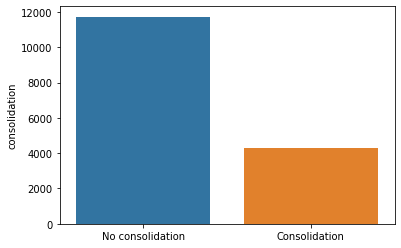

In [3]:
sns.barplot(['No consolidation', 'Consolidation'],files['consolidation'].value_counts())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


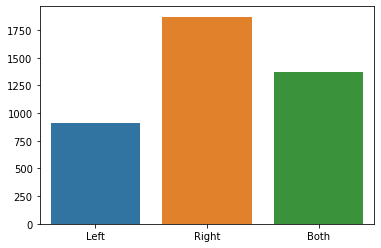

In [4]:
left=0
right=0
both=0

for i,row in files.iterrows():
  if ((row['consolidation-left']==1) & (row['consolidation-right']==1)):
    both+=1
  elif (row['consolidation-left']==1) :
    left+=1
  elif (row['consolidation-right']==1):
    right+=1

sns.barplot(['Left','Right','Both'],[left,right,both])

- It can be seen that there is a high imbalance in dataset. 
- Inorder to balance this we can either create images synthetically or drop a few of the negative images 
- Inorder to get a balanced dataset, we will be taking all of the positive images and same number of negative xrays which are randomly sampled


In [5]:
positive_files=files[files['consolidation']==1]['filename'].index
negative_files=files[files['consolidation']==0]['filename'].index
print(len(negative_files) ,'  negative files')
print(len(positive_files) ,' positive files')

11726   negative files
4274  positive files


In [6]:
negative_files=random.sample(list(negative_files),len(positive_files))
print(len(negative_files) ,'  negative files after balancing')
print(len(positive_files) ,' positive files after balancing')

4274   negative files after balancing
4274  positive files after balancing


In [7]:
xray_files=np.append(positive_files,negative_files)
del positive_files
del negative_files
print(len(xray_files), 'training samples will be used')

8548 training samples will be used


In [8]:
from sklearn.utils import shuffle
xray_files=shuffle(xray_files)
train=xray_files[0:int(len(xray_files)*0.8)]
test=xray_files[int(len(xray_files)*0.8):]

print('Train data : ',len(train))
print('Test data: ',len(test))

Train data :  6838
Test data:  1710


In [9]:
train_df = files.iloc[train]
test_df = files.iloc[test]

In [12]:
train_df.head()

,filename,consolidation,consolidation-left,consolidation-right
14086,3944,1,0,1
14976,8768,1,0,1
15167,4169,1,0,1
1086,5757,0,0,0
2335,18985,0,0,0


In [36]:
filenames=train_df['filename'].values
images=[]
binary=[]
detailed=[]
file_path='cxr_plaksha_assignment_qure/'
for file in tqdm(filenames):
  file_name=str(file)+'.png'
  try:
      image=cv2.imread(file_path+file_name)
      image= cv2.resize(image,(400,400))
      image_array=np.array(image)
      images.append(image_array)
      binary.append(train_df[train_df['filename']==file]['consolidation'].values[0])
      detailed.append([train_df[train_df['filename']==file]['consolidation-left'].values[0],train_df[train_df['filename']==file]['consolidation-right'].values[0]])
  except:
      print(file,' not found')
np.savez('/content/drive/MyDrive/Colab Notebooks/Covid Chest Xray/train.npz',data=np.array(images),label=np.array(binary),consolidation=np.array(detailed))

100%|██████████| 6838/6838 [04:21<00:00, 26.10it/s]


In [32]:
filenames=test_df['filename'].values
images=[]
binary=[]
detailed=[]
file_path='cxr_plaksha_assignment_qure/'
for file in tqdm(filenames):
  file_name=str(file)+'.png'
  try:
      image=cv2.imread(file_path+file_name)
      image= cv2.resize(image,(400,400))
      image_array=np.array(image)
      images.append(image_array)
      binary.append(test_df[test_df['filename']==file]['consolidation'].values[0])
      detailed.append([test_df[test_df['filename']==file]['consolidation-left'].values[0],test_df[test_df['filename']==file]['consolidation-right'].values[0]])
  except:
      print(file,' not found')
np.savez('test.npz',data=np.array(images),label=np.array(binary),consolidation=np.array(detailed))

100%|██████████| 1710/1710 [00:56<00:00, 30.12it/s]


### Saving the npz files to google drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import os
for file in tqdm(os.listdir()):
  try:
    if file.split('.')[1]=='npz':
      shutil.copy(file,'/content/drive/MyDrive/Colab Notebooks/Covid Chest Xray')
  except:
    pass

100%|██████████| 8/8 [00:31<00:00,  3.97s/it]


## Misc


In [ ]:
# # Seperating the test dataset

# file_list=files['filename']
# import os
# images=[]
# for file in os.listdir('/content/cxr_plaksha_assignment_qure'):
#   try:
#     if file.split('.')[1]=='png':
#       if file.split('.')[0] not in file_list:
#         images.append(str(file))
#   except:
#     print(file)
# np.savez('test_images.npz',data=images)